# 🎯 Training and Prediction Function for Models

- Prepares a model for training.
- Performs predictions after training.
- Is reusable for multiple model types in this notebook.


## 📦 Essential Library Imports



In [52]:
import pandas as pd
import numpy as np
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import plotly.express as px
from sklearn.metrics import mean_absolute_error, accuracy_score
import warnings  # To suppress warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
def predict_2024_for_model(model_name, df, df_2024, states, features):
    """
    Predict the winner for each state using the given model.

    Parameters:
    - model_name: Name of the saved model.
    - df: Historical training data (DataFrame).
    - df_2024: Testing data for 2024 predictions (DataFrame).
    - states: List of states to evaluate.
    - features: Features used for prediction.

    Returns:
    - state_to_pred: Dictionary mapping states to predicted winners.
    """
    # Load the pre-trained model
    with open(f"model/{model_name}.pkl", "rb") as f:
        model = pickle.load(f)

    state_to_pred = {}

    for state in states:
        # Filter training and testing data for the current state
        train_data = df[df['state'] == state].copy()
        test_data = df_2024[df_2024['state'] == state].copy()

        if train_data.empty:
            print(f"No training data for state: {state}")
            continue
        if test_data.empty:
            print(f"No testing data for state: {state}")
            continue

        # Prepare features and targets
        X_train = train_data[features]
        y_train = train_data['vote_share']
        X_test = test_data[features]

        # Train the model and predict outcomes
        model.fit(X_train, y_train)
        test_data[f'predicted_{model_name}'] = model.predict(X_test)

        # Aggregate predictions to determine the winning party
        aggregated_predictions = test_data.groupby('party', group_keys=False).apply(
            lambda df: np.average(df[f'predicted_{model_name}'])
        ).reset_index(name='aggregated_prediction')

        # Identify the predicted winner
        predicted_winner = aggregated_predictions.loc[
            aggregated_predictions['aggregated_prediction'].idxmax(), 'party'
        ]

        state_to_pred[state] = predicted_winner

    return state_to_pred

## 🗳️ Electoral Vote Calculation

- Computes the total electoral votes for each predicted party.

In [15]:
def calculate_electoral_votes(state_to_pred, electoral_votes):
    """
    Calculate electoral votes based on state predictions.

    Parameters:
    - state_to_pred: Dictionary of predicted winners for each state.
    - electoral_votes: Dictionary of electoral votes by state.

    Returns:
    - electoral_votes_by_candidate: Series with electoral votes grouped by winner.
    """
    # Convert predictions to a DataFrame
    state_predictions = pd.DataFrame(
        list(state_to_pred.items()), columns=['state', 'predicted_winner']
    )

    # Map electoral votes to states
    state_predictions['electoral_votes'] = state_predictions['state'].map(electoral_votes)

    # Sum electoral votes by predicted winner
    electoral_votes_by_candidate = state_predictions.groupby('predicted_winner')[
        'electoral_votes'
    ].sum()

    return electoral_votes_by_candidate

## 🗺️ Generate Map Visualization



In [16]:
def plot_predictions_on_map(state_to_pred, geojson_url, model_name):
    """
    Plot state predictions on a US map.

    Parameters:
    - state_to_pred: Dictionary of predicted winners for each state.
    - geojson_url: URL to GeoJSON file for US states.
    - model_name: Name of the model used for predictions.
    """
    # Load US states GeoJSON data
    us_states = gpd.read_file(geojson_url)

    # Prepare prediction data for merging
    state_predictions = pd.DataFrame(
        list(state_to_pred.items()), columns=['state', 'predicted_winner']
    )

    # Merge predictions with geographic data
    us_states = us_states.merge(state_predictions, left_on="name", right_on="state", how="left")
    us_states["predicted_winner"] = us_states["predicted_winner"].fillna("Unknown")
    us_states["color"] = us_states["predicted_winner"].map({"DEM": "blue", "REP": "red", "Unknown": "gray"})

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    us_states.boundary.plot(ax=ax, linewidth=1)
    us_states.plot(ax=ax, color=us_states["color"], legend=True)

    plt.title(f"US Presidential Predictions by State ({model_name})", fontsize=16)
    plt.axis("off")
    plt.show()

## 📊 Running Predictions and Generating Results

In [17]:
# Define parameters
models = ["LinearRegression", "RandomForest", "DecisionTree", "XGBoost"]
features = [
    'pct_estimate', 'days_until_election', 'is_incumbent_pres',
    'is_incumbent_vp', 'is_incumbent_party', 'party_DEM', 'party_REP'
]
geojson_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"

# Load datasets
df = pd.read_csv('dataset/polling_data_with_features.csv')
df_2024 = pd.read_csv('dataset/2024_polling_data_with_features.csv')

# Electoral votes dictionary
electoral_votes = {
    'Alabama': 9, 'Alaska': 3, 'Arizona': 11, 'Arkansas': 6, 'California': 55,
    'Colorado': 10, 'Connecticut': 7, 'Delaware': 3, 'District of Columbia': 3,
    'Florida': 29, 'Georgia': 16, 'Hawaii': 4, 'Idaho': 4, 'Illinois': 20,
    'Indiana': 11, 'Iowa': 6, 'Kansas': 6, 'Kentucky': 8, 'Louisiana': 8,
    'Maine': 4, 'Maryland': 10, 'Massachusetts': 11, 'Michigan': 16,
    'Minnesota': 10, 'Mississippi': 6, 'Missouri': 10, 'Montana': 3,
    'Nebraska': 5, 'Nevada': 6, 'New Hampshire': 4, 'New Jersey': 14,
    'New Mexico': 5, 'New York': 29, 'North Carolina': 15, 'North Dakota': 3,
    'Ohio': 18, 'Oklahoma': 7, 'Oregon': 7, 'Pennsylvania': 20,
    'Rhode Island': 4, 'South Carolina': 9, 'South Dakota': 3, 'Tennessee': 11,
    'Texas': 38, 'Utah': 6, 'Vermont': 3, 'Virginia': 13, 'Washington': 12,
    'West Virginia': 5, 'Wisconsin': 10, 'Wyoming': 3
}

# Define states (list of all states)
states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut",
    "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana",
    "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts",
    "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska",
    "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina",
    "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island",
    "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont",
    "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

# Predict and analyze for each model with progress bar
for model_name in tqdm(models, desc="Running predictions for models"):
    # Predict for 2024
    state_to_pred = predict_2024_for_model(model_name, df, df_2024, states, features)

    # Calculate electoral votes
    electoral_votes_by_candidate = calculate_electoral_votes(state_to_pred, electoral_votes)


Running predictions for models: 100%|██████████| 4/4 [00:19<00:00,  4.87s/it]


Processing models:   0%|          | 0/4 [00:00<?, ?it/s]


               Electoral Votes by Candidate:                
Model:                LinearRegression  
Harris (DEM):               247         
Trump (REP):                289         
Winner:                    Trump        



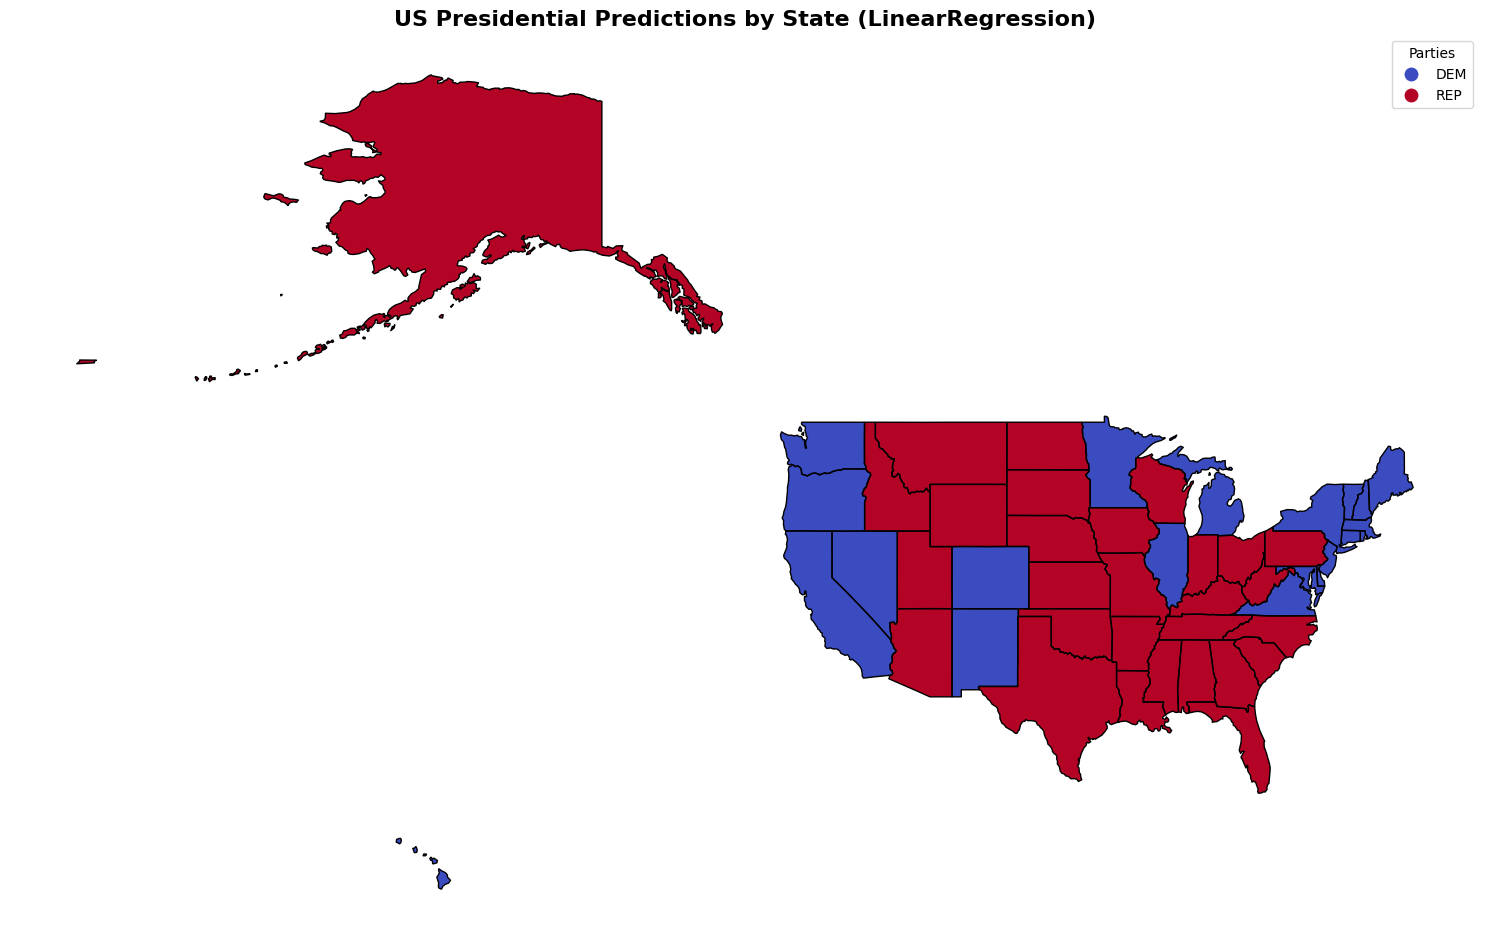

Processing models:  25%|██▌       | 1/4 [00:01<00:03,  1.32s/it]


               Electoral Votes by Candidate:                
Model:                  RandomForest    
Harris (DEM):               267         
Trump (REP):                269         
Winner:                    Trump        



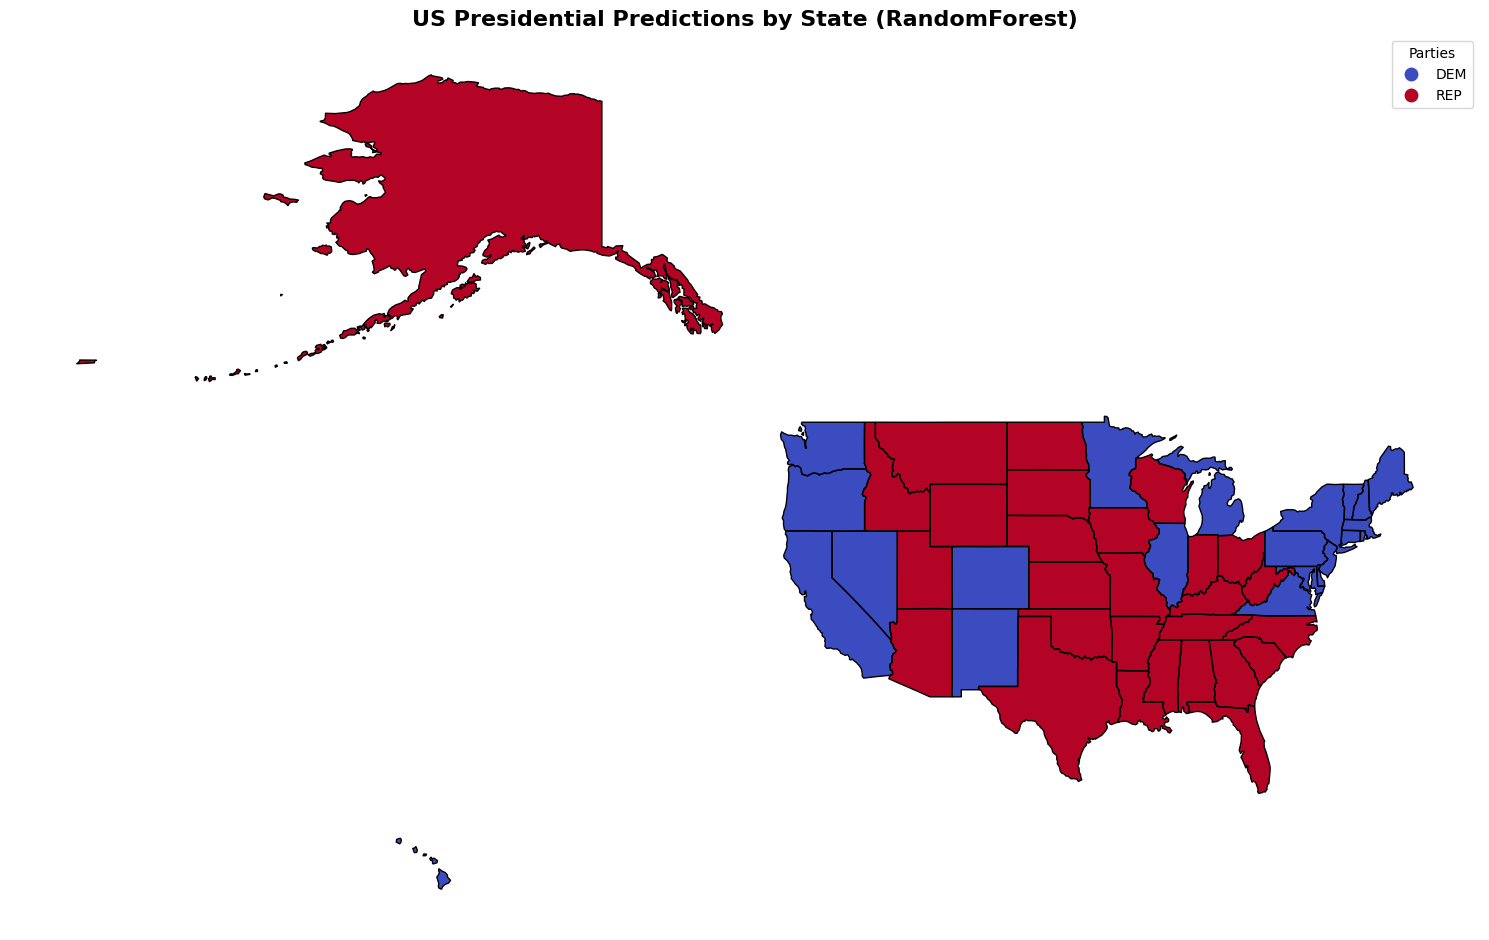

Processing models:  50%|█████     | 2/4 [00:15<00:18,  9.01s/it]


               Electoral Votes by Candidate:                
Model:                  DecisionTree    
Harris (DEM):               267         
Trump (REP):                269         
Winner:                    Trump        



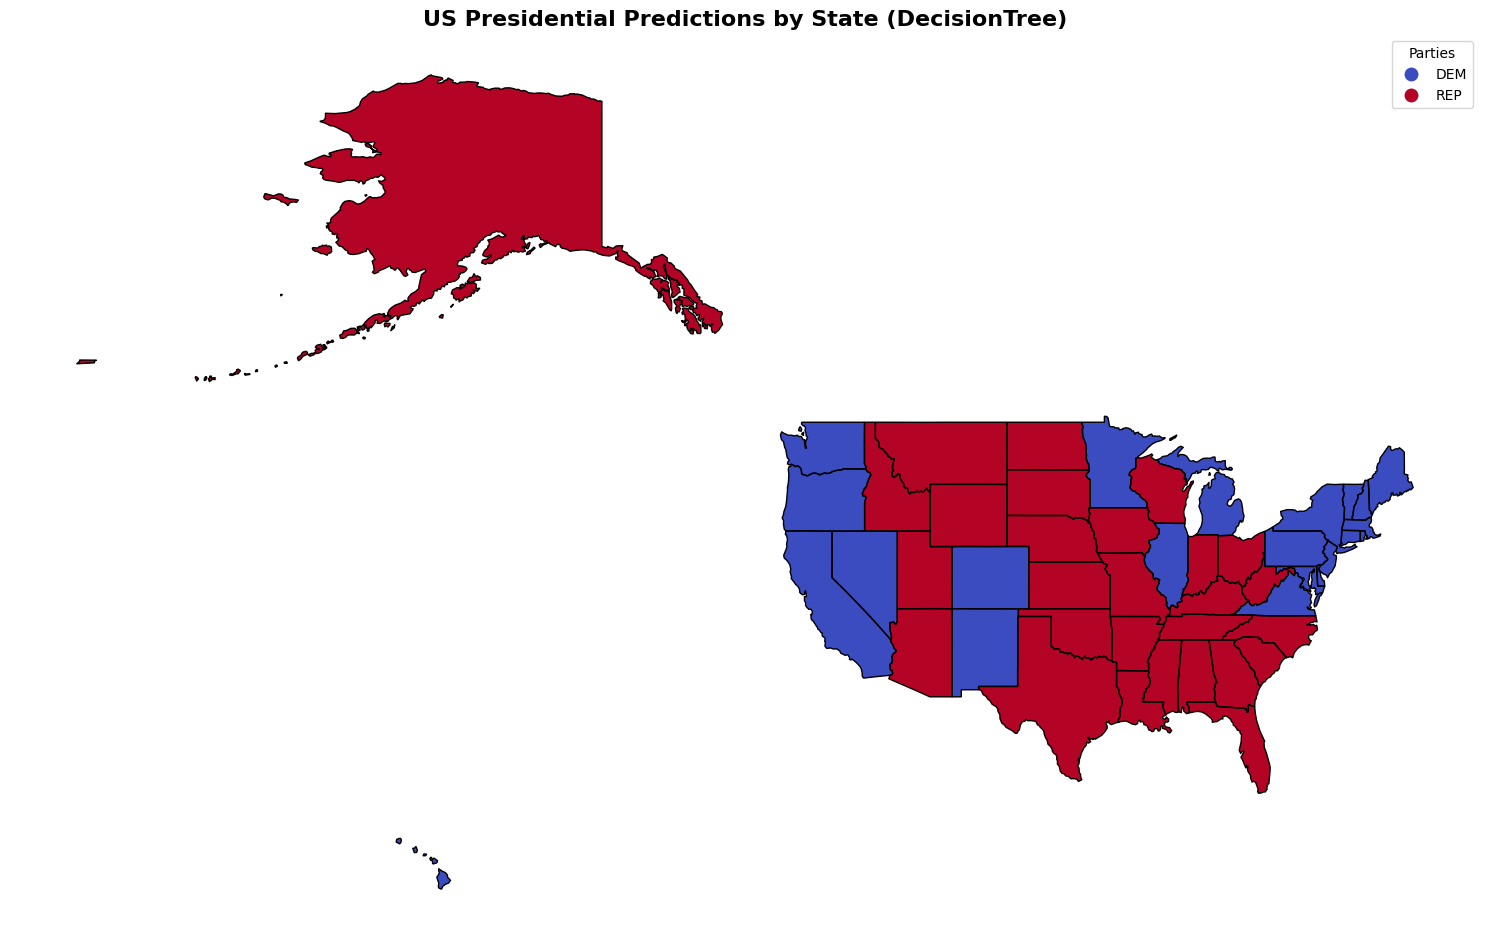

Processing models:  75%|███████▌  | 3/4 [00:16<00:05,  5.45s/it]


               Electoral Votes by Candidate:                
Model:                    XGBoost       
Harris (DEM):               267         
Trump (REP):                269         
Winner:                    Trump        



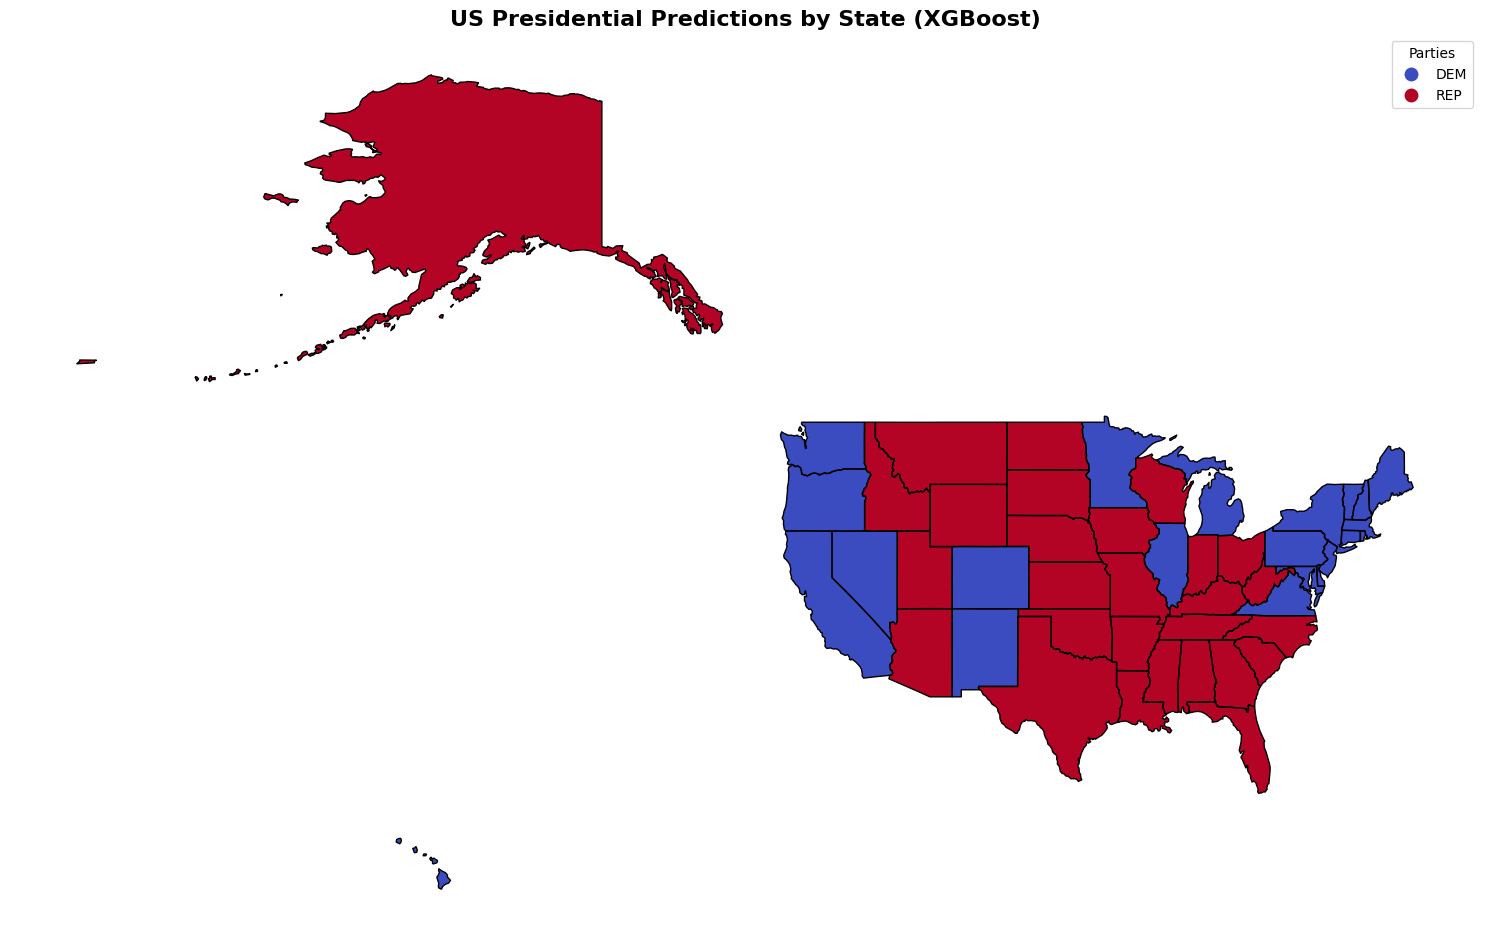

Processing models: 100%|██████████| 4/4 [00:21<00:00,  5.30s/it]


In [46]:
for model_name in tqdm(models, desc="Processing models"):
    # Predict for 2024
    state_to_pred = predict_2024_for_model(model_name, df, df_2024, states, features)

    # Calculate electoral votes
    electoral_votes_by_candidate = calculate_electoral_votes(state_to_pred, electoral_votes)

    # Extract vote totals and determine the winner
    dem_votes = electoral_votes_by_candidate.get("DEM", 0)
    rep_votes = electoral_votes_by_candidate.get("REP", 0)
    winner = "Harris" if dem_votes > rep_votes else "Trump"

    # Create a bordered output
    print("\n" + "=" * 60)
    print(f"{'Electoral Votes by Candidate:':^60}")
    print("=" * 60)
    print(f"{'Model:':<20}{model_name:^20}")
    print(f"{'Harris (DEM):':<20}{dem_votes:^20}")
    print(f"{'Trump (REP):':<20}{rep_votes:^20}")
    print(f"{'Winner:':<20}{winner:^20}")
    print("=" * 60 + "\n")

    # Load map and merge predictions
    us_states = gpd.read_file(geojson_url)
    state_predictions = pd.DataFrame(
        list(state_to_pred.items()), columns=['state', 'predicted_winner']
    )
    us_states = us_states.merge(state_predictions, left_on="name", right_on="state", how="inner")

    # Plot map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    us_states.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    us_states.plot(
        ax=ax,
        column="predicted_winner",
        legend=True,
        cmap="coolwarm",
        legend_kwds={"title": "Parties"}
    )

    # Title and show map
    ax.set_title(f"US Presidential Predictions by State ({model_name})", fontsize=16, fontweight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## 📊 Model Comparison: Electoral Votes vs Real-Life Results

This section compares the electoral vote predictions from different models with the real-life results. The comparison includes:
- **Baseline Model (Bayesian)**: Our initial test model, which used aggregated statistics for predictions based on polling weights.
- **Linear Regression, Random Forest, Decision Tree, and XGBoost**: Advanced models run in this notebook with increasing complexity.
- **Real-Life Results**: The actual electoral votes received by Harris and Trump.

The purpose of this comparison is to evaluate the models and identify which one aligns most closely with the real-life results, providing the most accurate prediction.

In [49]:
# Import the baseline metrics CSV from the data folder
baseline_metrics = pd.read_csv("dataset/baseline_metrics.csv")

# Real-life results (as provided)
real_evotes = {'Harris': 226, 'Trump': 312}
real_winner = 'Trump'

# Current models' votes (from the notebook)
current_model_votes = [
    {'Model': 'Baseline Model (Bayesian)', 'Harris': 289, 'Trump': 249, 'Winner': 'Harris'},
    {'Model': 'LinearRegression', 'Harris': 247, 'Trump': 289, 'Winner': 'Trump'},
    {'Model': 'RandomForest', 'Harris': 267, 'Trump': 269, 'Winner': 'Trump'},
    {'Model': 'DecisionTree', 'Harris': 267, 'Trump': 269, 'Winner': 'Trump'},
    {'Model': 'XGBoost', 'Harris': 267, 'Trump': 269, 'Winner': 'Trump'}
]

# Add real-life result as the last row
current_model_votes.append({'Model': 'Real-Life Result', 'Harris': real_evotes['Harris'], 'Trump': real_evotes['Trump'], 'Winner': real_winner})

# Convert the list of dictionaries into a DataFrame
votes_comparison_df = pd.DataFrame(current_model_votes)

# Add a Correct Prediction column
votes_comparison_df['Correct Prediction'] = votes_comparison_df['Winner'].apply(lambda winner: '✓' if winner == real_winner else '✗')

# Display the table for comparison with centered headers and values
print("\nElectoral Vote Comparison Table:")
display(votes_comparison_df.style.set_table_styles(
    [
        {"selector": "thead th", "props": [("background-color", "lightblue"), ("font-weight", "bold"), ("text-align", "center")]},
        {"selector": "tbody td", "props": [("text-align", "center")]}
    ]
))


Electoral Vote Comparison Table:


,Model,Harris,Trump,Winner,Correct Prediction
0,Baseline Model (Bayesian),289,249,Harris,✗
1,LinearRegression,247,289,Trump,✓
2,RandomForest,267,269,Trump,✓
3,DecisionTree,267,269,Trump,✓
4,XGBoost,267,269,Trump,✓
5,Real-Life Result,226,312,Trump,✓


In [53]:
# Real-life results
real_evotes = {'Harris': 226, 'Trump': 312}

# Create a DataFrame to store metrics for all models
metrics_list = []

# Iterate through all models (excluding the real-life result row)
for _, row in votes_comparison_df[:-1].iterrows():
    # Calculate Mean Absolute Error (MAE) for Harris and Trump
    mae_harris = mean_absolute_error([real_evotes['Harris']], [row['Harris']])
    mae_trump = mean_absolute_error([real_evotes['Trump']], [row['Trump']])

    # Calculate State-Level Accuracy (based on Winner column)
    predicted_winner = row['Winner']
    state_accuracy = 1 if predicted_winner == 'Trump' else 0  # 1 if prediction is correct, else 0

    # Append metrics to the list
    metrics_list.append({
        'Model': row['Model'],
        'MAE_Harris': mae_harris,
        'MAE_Trump': mae_trump,
        'State_Accuracy': state_accuracy
    })

# Convert metrics into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Display the metrics table
print("\nModel Metrics Comparison:")
display(metrics_df.style.set_table_styles(
    [
        {"selector": "thead th", "props": [("background-color", "lightblue"), ("font-weight", "bold"), ("text-align", "center")]},
        {"selector": "tbody td", "props": [("text-align", "center")]}
    ]
))

# Save the metrics table to a CSV file (optional)
metrics_df.to_csv("./result/model_metrics_comparison.csv", index=False)


Model Metrics Comparison:


,Model,MAE_Harris,MAE_Trump,State_Accuracy
0,Baseline Model (Bayesian),63.000000,63.000000,0
1,LinearRegression,21.000000,23.000000,1
2,RandomForest,41.000000,43.000000,1
3,DecisionTree,41.000000,43.000000,1
4,XGBoost,41.000000,43.000000,1


## 🏆 Final Evaluation and Insights

### Key Metrics:
- **Baseline Model (Bayesian)**:
  - The **Mean Absolute Error (MAE)** for both Harris (63) and Trump (63) is quite high, showing that the predictions weren’t very accurate.
  - The model also predicted the wrong winner, resulting in a **State Accuracy** of 0% since it didn’t match the actual election outcome.

- **Linear Regression**:
  - This model has the **lowest MAE** for both Harris (21) and Trump (23), meaning it predicted electoral votes with the least error compared to the other models.
  - It also predicted the **correct winner (Trump)**, achieving **State Accuracy** of 100%.

- **Random Forest, Decision Tree, XGBoost**:
  - These models had similar MAE values (41 for Harris and 43 for Trump), which are higher than Linear Regression but still better than the Baseline.
  - All of these models predicted the correct winner (Trump), so their **State Accuracy** was also 100%.

### Best Model: **Linear Regression**
- **Why It Stands Out**:
  - **Linear Regression** had the **lowest MAE**, meaning it was the most accurate in predicting the electoral votes for both Harris and Trump.
  - Plus, it correctly predicted the winner (Trump) and achieved perfect **State Accuracy**.

### Performance Analysis:
1. **Baseline Model Weakness**:
   - The **Bayesian Model** relied on aggregated polling data, which overestimated Harris’s votes and didn’t account for actual trends well.
   - Since it got the winner wrong, its **State Accuracy** was 0%, showing it didn’t perform well with this data.

2. **Advanced Models (Random Forest, Decision Tree, XGBoost)**:
   - Even though **Random Forest**, **Decision Tree**, and **XGBoost** predicted the correct winner, their **MAE** was higher than Linear Regression, meaning they weren’t as accurate.
   - These models may have **overfitted** the data, trying to capture patterns that weren’t actually there, which caused their predictions to be less precise.

3. **Conclusion**:
   - **Linear Regression** performed the best because it was **simple**, **accurate**, and didn’t overcomplicate things like the more complex models did.
   - While **Random Forest** and **XGBoost** are generally better for capturing complex patterns, they didn’t do as well on this dataset, likely due to overfitting.
   - **Final Thoughts**: For this specific task, **Linear Regression** offered the best balance of **accuracy** and **generalization**, making it the most reliable model to use here.
